!pip install pandas
!pip install matplotlib
!pip install plotly

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *

import math
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.io import savemat
from scipy import interpolate
from sklearn.model_selection import train_test_split

import plotly.graph_objects as go
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy.matlib
from scipy.special import expit

import time
import os

In [2]:
from numpy.random import seed
seed(0)
tf.random.set_seed(0)

# 1. Import the data

In [3]:
data_x = np.loadtxt(open('real_data/INTC.csv',"rb"),delimiter=",",skiprows=0)[:,0:1]
data_y = np.loadtxt(open('real_data/MSFT.csv',"rb"),delimiter=",",skiprows=0)[:,0:1]
data = np.concatenate((data_x,data_y),axis=1)
print(data.shape)

(1263, 2)


In [4]:
for i in range(data.shape[-1]):
    data[:,i] = (data[:,i]-np.min(data[:,i]))/(np.max(data[:,i]-np.min(data[:,i])))
X_train, X_test = train_test_split(data,test_size=0.33, random_state=42)

# 2. Check data infomation

In [5]:
number_of_dimension = data.shape[1]
number_of_training_samples = X_train.shape[0]
number_of_testing_samples = X_test.shape[0]
data_domain = np.asarray([[np.min(X_train[:,i]),np.max(X_train[:,i])] for i in range(number_of_dimension)])
print('number_of_dimension:',number_of_dimension)
print('number_of_training_samples:',number_of_training_samples)
print('number_of_testing_samples:',number_of_testing_samples)
print('data_domain:\n',data_domain)

number_of_dimension: 2
number_of_training_samples: 846
number_of_testing_samples: 417
data_domain:
 [[3.3830221e-04 9.8466396e-01]
 [0.0000000e+00 1.0000000e+00]]


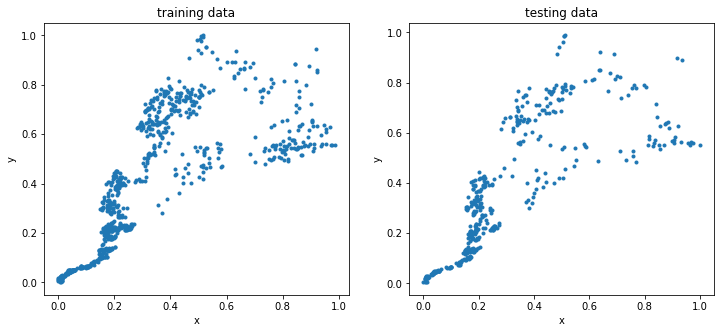

In [6]:
if number_of_dimension==2:
    fig, axs = plt.subplots(1,2,constrained_layout=False, figsize=(12, 5))
    #
    ax = axs.ravel()[0]
    ax.scatter(X_train[:,0], X_train[:,1], marker='.')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('training data')
    #
    ax = axs.ravel()[1]
    ax.scatter(X_test[:,0], X_test[:,1], marker='.')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('testing data')
if number_of_dimension==3:
    fig = plt.figure(figsize=plt.figaspect(0.5))
    #
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.scatter(X_train[:,0], X_train[:,1], X_train[:,2], marker='.')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('training data')
    #
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter(X_test[:,0], X_test[:,1], X_test[:,2], marker='.')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('testing data')

# 3. Define the network

In [7]:
num_hidden_layers_for_marginal_distribution = 5
hidden_layer_width_for_marginal_distribution = 5
num_hidden_layers_for_copula = 5
hidden_layer_width_for_copula = 10

In [8]:
class _marginal(keras.Model):

    def __init__(self):
        super(_marginal, self).__init__()
        self.kernel_regularizer = tf.keras.regularizers.L2(l2=0.001)
        self.dense_layer_list = [keras.layers.Dense(hidden_layer_width_for_marginal_distribution, activation='tanh',
                                                    kernel_regularizer=self.kernel_regularizer) for i in range(num_hidden_layers_for_marginal_distribution)]
        self.final_layer = keras.layers.Dense(1, activation='sigmoid',kernel_regularizer=self.kernel_regularizer)
        self.gradient_layers = Lambda(lambda x: K.gradients(x[0],x[1]))
        self.relu = keras.layers.ReLU()
    
    def call(self, inputs):
        x=inputs
        for i in range(num_hidden_layers_for_marginal_distribution):
            x = self.dense_layer_list[i](x)
        cdf = self.final_layer(x)
        pdf = self.gradient_layers([cdf,inputs])
        
        neg = self.relu(-pdf[0])
        pdf = 1e-9+self.relu(pdf[0])
        
        return [cdf,pdf,neg]

In [9]:
class _copula(keras.Model):

    def __init__(self):
        super(_copula, self).__init__()
        self.kernel_regularizer = tf.keras.regularizers.L2(l2=0.001)
        self.get_components = Lambda(lambda x: [x[:,i:i+1] for i in range(number_of_dimension)])
        self.cat_components = Lambda(lambda x: K.concatenate(x, axis=-1))
        self.dense_layer_list = [keras.layers.Dense(hidden_layer_width_for_copula, activation='tanh',
                                                    kernel_regularizer=self.kernel_regularizer) for i in range(num_hidden_layers_for_copula)]
        self.final_layer = keras.layers.Dense(1, activation='sigmoid',kernel_regularizer=self.kernel_regularizer)
        self.gradient_layers = Lambda(lambda x: K.gradients(x[0],x[1]))
        self.relu = keras.layers.ReLU()
    
    def call(self, inputs):
        components = self.get_components(inputs)
        x = self.cat_components(components)
        for i in range(num_hidden_layers_for_copula):
            x = self.dense_layer_list[i](x)
        cdf = self.final_layer(x)
        pdf = cdf
        
        for i in range(number_of_dimension):
            pdf = self.gradient_layers([pdf,components[i]])
        
        neg = self.relu(-pdf[0])
        pdf = 1e-9+self.relu(pdf[0])
        
        return [cdf,pdf,neg]

In [10]:
marginal_model_list = [_marginal() for i in range(number_of_dimension)]
copula_model = _copula()

In [11]:
marginal_prediction_input_list=[keras.layers.Input(shape=(1,)) for i in range(number_of_dimension)]
marginal_prediction_output_list=[marginal_model_list[i](marginal_prediction_input_list[i]) for i in range(number_of_dimension)]
copula_prediction_input=keras.layers.Input(shape=(number_of_dimension,))
copula_prediction_output=copula_model(copula_prediction_input)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

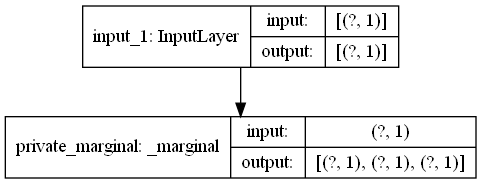

In [12]:
marginal_prediction_model_list = [keras.Model(inputs=marginal_prediction_input_list[i],
                                              outputs=marginal_prediction_output_list[i]) 
                                  for i in range(number_of_dimension)]
tf.keras.utils.plot_model(marginal_prediction_model_list[0], show_shapes=True, show_layer_names=True, 
                          to_file='marginal_prediction_model.png')

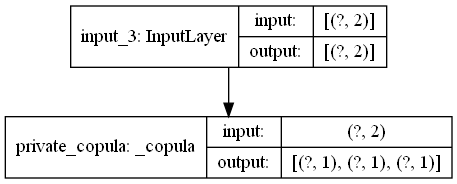

In [13]:
copula_prediction_model = keras.Model(inputs=copula_prediction_input,outputs=copula_prediction_output)
tf.keras.utils.plot_model(copula_prediction_model, show_shapes=True, show_layer_names=True, 
                          to_file='copula_prediction_model.png')

# 4. Training

## 4.1. Estimate marginal distributions

In [14]:
number_marginal_points = 1000

### 4.1.1. Prepare data

In [15]:
marginal_boundary_loss_data_list = [np.expand_dims(data_domain[i],axis=[0,-1]) for i in range(number_of_dimension)]
marginal_neg_sum_loss_data_list = [np.expand_dims(np.linspace(data_domain[i,0],data_domain[i,1],number_marginal_points),axis=[0,-1]) for i in range(number_of_dimension)]
marginal_log_loss_data_list = [np.expand_dims(X_train[:,i],axis=[0,-1]) for i in range(number_of_dimension)]
print('marginal_boundary_loss_data_list: d x',marginal_boundary_loss_data_list[0].shape)
print('marginal_neg_sum_loss_data_list: d x',marginal_neg_sum_loss_data_list[0].shape)
print('marginal_log_loss_data_list: d x',marginal_log_loss_data_list[0].shape)
marginal_training_input_data=marginal_boundary_loss_data_list+marginal_neg_sum_loss_data_list+marginal_log_loss_data_list

marginal_boundary_loss_data_list: d x (1, 2, 1)
marginal_neg_sum_loss_data_list: d x (1, 1000, 1)
marginal_log_loss_data_list: d x (1, 846, 1)


In [16]:
marginal_boundary_loss_label_list = [np.expand_dims([0.0,1.0],axis=0) for i in range(number_of_dimension)]
marginal_neg_loss_label_list = [np.expand_dims([0.0,],axis=0) for i in range(number_of_dimension)]
marginal_sum_loss_label_list = [np.expand_dims([1.0,],axis=0) for i in range(number_of_dimension)]
marginal_log_loss_label_list = [np.expand_dims([5.0,],axis=0) for i in range(number_of_dimension)]
print('marginal_boundary_loss_label_list: d x',marginal_boundary_loss_label_list[0].shape)
print('marginal_neg_loss_label_list: d x',marginal_neg_loss_label_list[0].shape)
print('marginal_sum_loss_label_list: d x',marginal_sum_loss_label_list[0].shape)
print('marginal_log_loss_label_list: d x',marginal_log_loss_label_list[0].shape)
marginal_training_labels=marginal_boundary_loss_label_list+marginal_neg_loss_label_list+marginal_sum_loss_label_list+marginal_log_loss_label_list

marginal_boundary_loss_label_list: d x (1, 2)
marginal_neg_loss_label_list: d x (1, 1)
marginal_sum_loss_label_list: d x (1, 1)
marginal_log_loss_label_list: d x (1, 1)


### 4.1.2. Prepare training framework

In [17]:
marginal_boundary_loss_input_list = [keras.layers.Input(shape=(2,1)) for i in range(number_of_dimension)]
marginal_neg_sum_loss_input_list = [keras.layers.Input(shape=(number_marginal_points,1)) for i in range(number_of_dimension)]
marginal_log_loss_input_list = [keras.layers.Input(shape=(number_of_training_samples,1)) for i in range(number_of_dimension)]
print('marginal_boundary_loss_input_list: d x',marginal_boundary_loss_input_list[0].shape)
print('marginal_neg_sum_loss_input_list: d x',marginal_neg_sum_loss_input_list[0].shape)
print('marginal_log_loss_input_list: d x',marginal_log_loss_input_list[0].shape)
marginal_loss_input_list = marginal_boundary_loss_input_list+marginal_neg_sum_loss_input_list+marginal_log_loss_input_list

marginal_boundary_loss_input_list: d x (None, 2, 1)
marginal_neg_sum_loss_input_list: d x (None, 1000, 1)
marginal_log_loss_input_list: d x (None, 846, 1)


In [18]:
marginal_boundary_loss_output_list = [Lambda(lambda x: tf.expand_dims(x,axis=0),name="MB{}".format(i))(marginal_model_list[i](marginal_boundary_loss_input_list[i][0,:,:])[0][:,0]) for i in range(number_of_dimension)]
marginal_neg_loss_output_list = [Lambda(lambda x: tf.math.reduce_sum(x,keepdims=True)/np.float32(number_marginal_points),name="MN{}".format(i))(marginal_model_list[i](marginal_neg_sum_loss_input_list[i][0,:,:])[2]) for i in range(number_of_dimension)]
marginal_sum_loss_output_list = [Lambda(lambda x: tf.math.reduce_sum(x,keepdims=True)*np.float32(data_domain[i,1]-data_domain[i,0])/np.float32(number_marginal_points-1),name="MS{}".format(i))(marginal_model_list[i](marginal_neg_sum_loss_input_list[i][0,:,:])[1]) for i in range(number_of_dimension)]
marginal_log_loss_output_list = [Lambda(lambda x: tf.math.reduce_sum(tf.math.log(x),keepdims=True)/np.float32(marginal_log_loss_input_list[0].shape[1]),name="ML{}".format(i))(marginal_model_list[i](marginal_log_loss_input_list[i][0,:,:])[1]) for i in range(number_of_dimension)]
print('marginal_boundary_loss_output_list: d x',marginal_boundary_loss_output_list[0].shape)
print('marginal_neg_loss_output_list: d x',marginal_neg_loss_output_list[0].shape)
print('marginal_sum_loss_output_list: d x',marginal_sum_loss_output_list[0].shape)
print('marginal_log_loss_output_list: d x',marginal_log_loss_output_list[0].shape)
marginal_loss_output_list = marginal_boundary_loss_output_list+marginal_neg_loss_output_list+marginal_sum_loss_output_list+marginal_log_loss_output_list

marginal_boundary_loss_output_list: d x (1, 2)
marginal_neg_loss_output_list: d x (1, 1)
marginal_sum_loss_output_list: d x (1, 1)
marginal_log_loss_output_list: d x (1, 1)


In [19]:
marginal_model_train = keras.Model(inputs=marginal_loss_input_list, 
                                   outputs=marginal_loss_output_list)

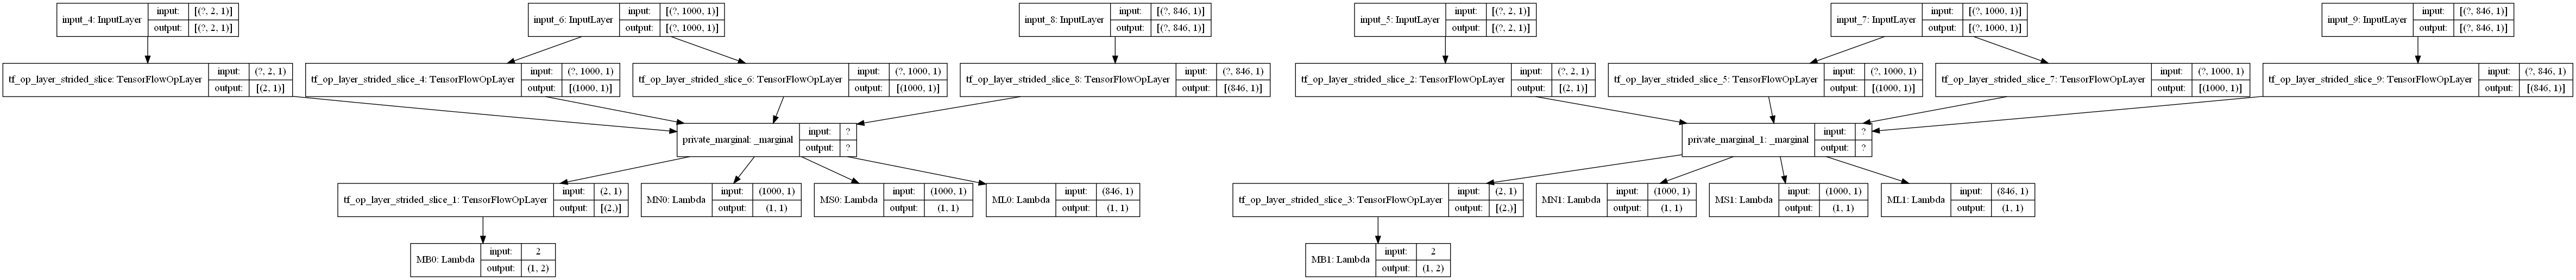

In [20]:
tf.keras.utils.plot_model(marginal_model_train, show_shapes=True, show_layer_names=True, to_file='marginal_model_train.png')

In [21]:
marginal_model_train.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.001), loss="mae")
marginal_model_train.save_weights('./initial_weights/marginal_model_initial_weights.h5')
temp_history = marginal_model_train.fit(x=marginal_training_input_data, y=marginal_training_labels, epochs=1, verbose=0)
marginal_loss_keys = []
for key in temp_history.history.keys():
    marginal_loss_keys.append(key)
print(marginal_loss_keys)

['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']


In [22]:
class Marginal_Model_Training_Callback(tf.keras.callbacks.Callback):
    def __init__(self, record_interval=10, show_interval=100, verbose=1):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.loss_keys = marginal_loss_keys
        self.previous_loss = 9999999
        self.record_interval = record_interval;
        self.show_interval = show_interval;
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        
        if epoch%self.record_interval == 0:
            
            current_losses = np.asarray([logs.get(self.loss_keys[i]) for i in range(len(self.loss_keys))])
            current_losses[-number_of_dimension:] = 5.0-current_losses[-number_of_dimension:]
            
            marginal_epoch_number_list.append(epoch)
            marginal_losses_list.append(current_losses)
        
            if current_losses[0] < self.previous_loss:
                self.previous_loss = current_losses[0]
                for i, marginal_model in enumerate(marginal_model_list):
                    marginal_model.save_weights('./best_weights/marginal_model_{}_best_weights.h5'.format(i))
            
            if self.verbose > 0:
                print('epoch:{}'.format(epoch))
                print([self.loss_keys[i] for i in range(len(self.loss_keys))])
                print(['{:.3f}'.format(current_losses[i]) for i in range(len(self.loss_keys))])
            
        if epoch%self.show_interval == 0:
            
            fig, axs = plt.subplots(1, len(marginal_prediction_model_list), figsize=(12, 3))
            
            for i, marginal_prediction_model in enumerate(marginal_prediction_model_list):
                cdf,pdf,_ = marginal_prediction_model.predict(np.linspace(0,1,100))
                axs[i].hist(X_train[:,i], bins=20, density=True,rwidth=0.7)
                axs[i].plot(np.linspace(0,1,100),pdf,'k-',np.linspace(0,1,100),cdf,'k--')

            plt.pause(1)

In [23]:
marginal_model_training_callback = [
    Marginal_Model_Training_Callback(record_interval=1000, show_interval=1000, verbose=1),
]

### 4.1.3. Training the model

epoch:0
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['62.421', '0.456', '0.502', '0.000', '0.004', '0.911', '1.000', '-2.344', '-16.926']


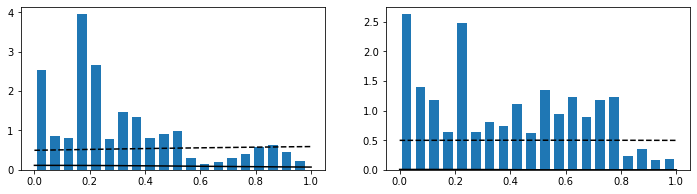

epoch:1000
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['21.408', '0.033', '0.128', '0.000', '0.000', '0.051', '0.257', '0.096', '-0.450']


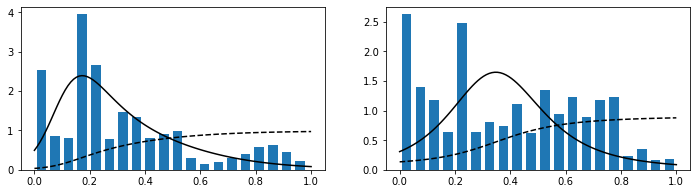

epoch:2000
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['20.738', '0.014', '0.084', '0.000', '0.000', '0.012', '0.168', '0.197', '-0.334']


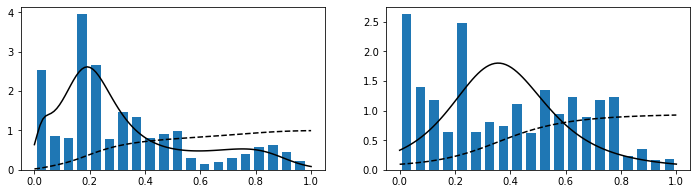

epoch:3000
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['19.919', '0.008', '0.050', '0.000', '0.000', '0.000', '0.100', '0.294', '-0.088']


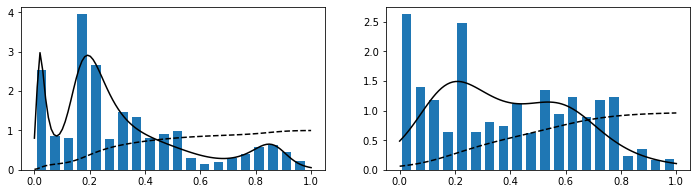

epoch:4000
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['19.486', '0.008', '0.023', '0.000', '0.000', '0.000', '0.045', '0.345', '0.034']


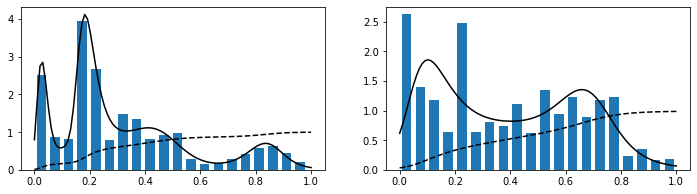

epoch:5000
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['19.323', '0.007', '0.012', '0.000', '0.000', '0.002', '0.024', '0.362', '0.087']


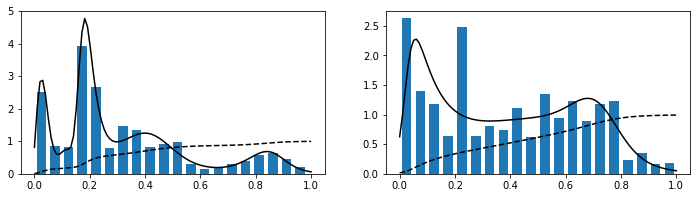

epoch:6000
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['19.226', '0.006', '0.007', '0.000', '0.000', '0.005', '0.013', '0.368', '0.123']


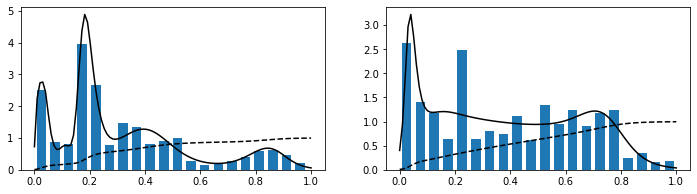

epoch:7000
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['19.180', '0.005', '0.006', '0.000', '0.000', '0.006', '0.012', '0.381', '0.134']


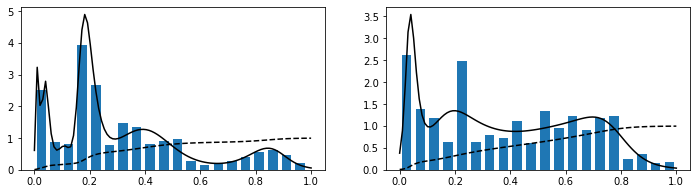

epoch:8000
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['19.154', '0.004', '0.005', '0.000', '0.000', '0.007', '0.010', '0.388', '0.140']


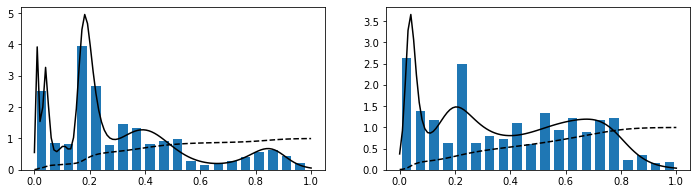

epoch:9000
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['19.140', '0.004', '0.004', '0.000', '0.000', '0.008', '0.009', '0.390', '0.143']


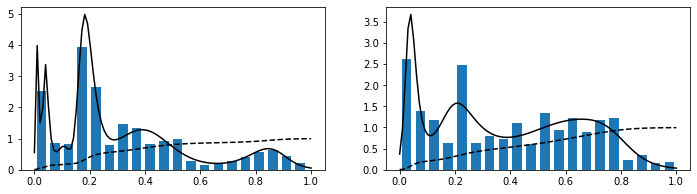

epoch:10000
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['19.126', '0.004', '0.004', '0.000', '0.000', '0.008', '0.008', '0.390', '0.149']


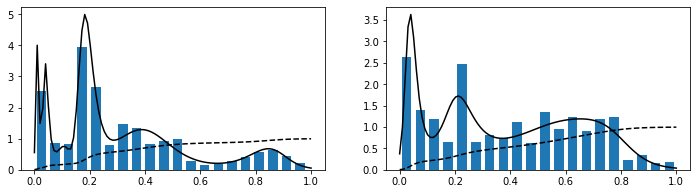

epoch:11000
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['19.076', '0.004', '0.004', '0.000', '0.000', '0.008', '0.007', '0.390', '0.178']


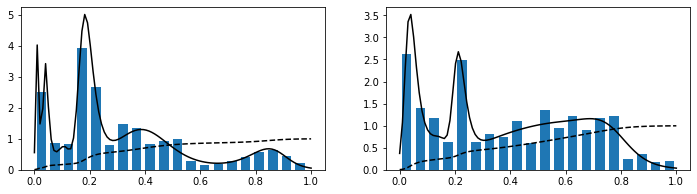

epoch:12000
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['19.024', '0.004', '0.003', '0.000', '0.000', '0.008', '0.006', '0.390', '0.210']


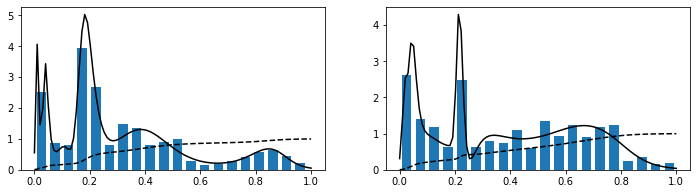

epoch:13000
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['18.994', '0.004', '0.003', '0.000', '0.000', '0.008', '0.005', '0.391', '0.223']


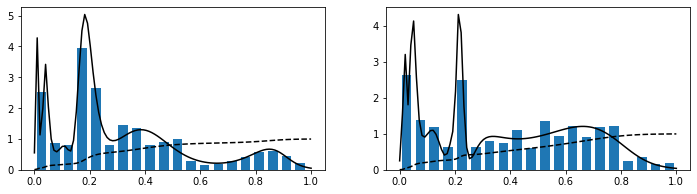

epoch:14000
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['18.973', '0.004', '0.002', '0.000', '0.001', '0.008', '0.004', '0.392', '0.232']


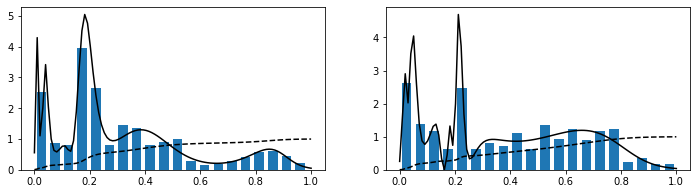

epoch:15000
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['18.968', '0.004', '0.002', '0.000', '0.001', '0.008', '0.004', '0.392', '0.232']


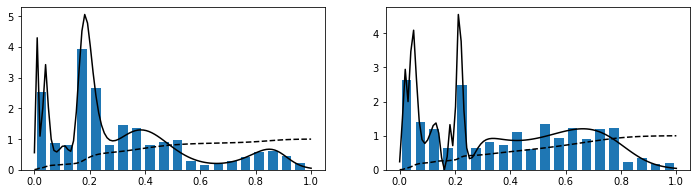

epoch:16000
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['18.965', '0.004', '0.002', '0.000', '0.001', '0.008', '0.004', '0.392', '0.233']


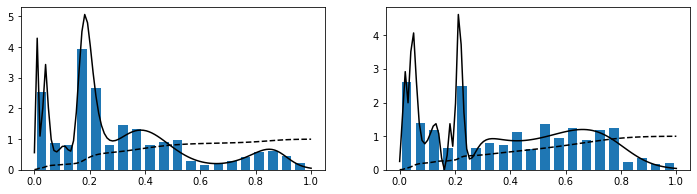

epoch:17000
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['18.963', '0.004', '0.003', '0.000', '0.001', '0.008', '0.004', '0.393', '0.233']


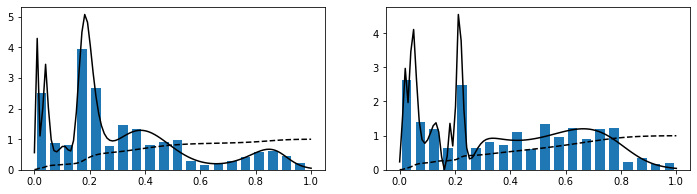

epoch:18000
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['18.962', '0.004', '0.003', '0.000', '0.001', '0.008', '0.003', '0.393', '0.233']


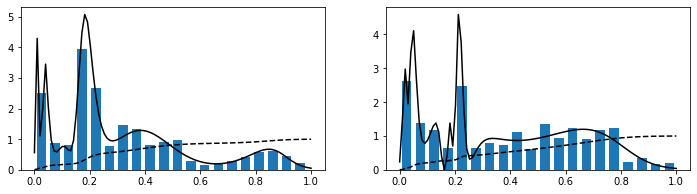

epoch:19000
['loss', 'MB0_loss', 'MB1_loss', 'MN0_loss', 'MN1_loss', 'MS0_loss', 'MS1_loss', 'ML0_loss', 'ML1_loss']
['18.960', '0.004', '0.003', '0.000', '0.001', '0.008', '0.004', '0.393', '0.233']


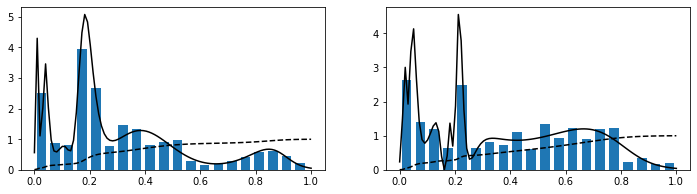

--- 106.5862979888916 seconds ---


In [24]:
marginal_epoch_number_list = []
marginal_losses_list = []
marginal_model_train.load_weights('./initial_weights/marginal_model_initial_weights.h5')
marginal_model_train.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.001), loss="mae", 
                             loss_weights = [2,2,2, 1,1,1, 2,2,2, 0.1,0.1,0.1])
start_time = time.time()
marginal_model_train.fit(x=marginal_training_input_data, y=marginal_training_labels, 
                         epochs=20000, verbose=0, callbacks=marginal_model_training_callback)
print("--- %s seconds ---" % (time.time() - start_time))

## 4.2. Estimate joint distributions

### 4.2.1. Prepare data

In [25]:
number_boundary_points = 400
number_partition_per_dim = 50
number_observation_points = 100 #10000

In [26]:
joint_boundary_loss_data = []
joint_boundary_loss_labels = []
for i in range(number_of_dimension):
    temp_data = np.random.rand(number_boundary_points,number_of_dimension)
    temp_data[:,i] = 0
    joint_boundary_loss_data.append(temp_data)
    joint_boundary_loss_labels.append(temp_data[:,i])
for i in range(number_of_dimension):
    temp_data = np.ones([number_boundary_points,number_of_dimension])
    temp_data[:,i] = np.random.rand(number_boundary_points)
    joint_boundary_loss_data.append(temp_data)
    joint_boundary_loss_labels.append(temp_data[:,i])
joint_boundary_loss_data = np.expand_dims(np.concatenate(joint_boundary_loss_data,axis=0),axis=0)
joint_boundary_loss_labels = np.expand_dims(np.concatenate(joint_boundary_loss_labels,axis=0),axis=0)

joint_neg_sum_loss_data = []
temp_data = np.meshgrid(*[np.linspace(0, 1, number_partition_per_dim) for i in range(number_of_dimension)])
for mesh in temp_data:
    joint_neg_sum_loss_data.append(mesh.view().ravel())
joint_neg_sum_loss_data = np.expand_dims(np.column_stack(joint_neg_sum_loss_data),axis=0)
joint_neg_loss_labels = np.zeros([1,1])
joint_sum_loss_labels = np.ones([1,1])

joint_log_loss_data = np.expand_dims(X_train,axis=0)
joint_log_loss_labels = np.zeros([1,1])+5.0

joint_observation_loss_data = np.expand_dims(np.random.rand(number_observation_points,number_of_dimension),axis=0)
joint_observation_loss_labels = np.zeros_like(joint_observation_loss_data[:,:,0])
for i,crd in enumerate(joint_observation_loss_data[0]):
    temp_flags = (X_train[:,0]<=crd[0])
    for d in range(1,number_of_dimension):
        temp_flags = np.logical_and(temp_flags,X_train[:,d]<=crd[d])
    joint_observation_loss_labels[0,i] = np.sum(temp_flags)/X_train.shape[0]

print('joint_boundary_loss_data:',joint_boundary_loss_data.shape)
print('joint_neg_sum_loss_data:',joint_neg_sum_loss_data.shape)
print('joint_log_loss_data:',joint_log_loss_data.shape)
print('joint_observation_loss_data:',joint_observation_loss_data.shape)

print('joint_boundary_loss_labels:',joint_boundary_loss_labels.shape)
print('joint_neg_loss_labels:',joint_neg_loss_labels.shape)
print('joint_sum_loss_labels:',joint_sum_loss_labels.shape)
print('joint_log_loss_labels:',joint_log_loss_labels.shape)
print('joint_observation_loss_labels:',joint_observation_loss_labels.shape)

joint_training_input_data=[joint_boundary_loss_data,joint_neg_sum_loss_data,joint_log_loss_data,joint_observation_loss_data]
joint_training_labels=[joint_boundary_loss_labels,joint_neg_loss_labels,joint_sum_loss_labels,joint_log_loss_labels,joint_observation_loss_labels]

joint_boundary_loss_data: (1, 1600, 2)
joint_neg_sum_loss_data: (1, 2500, 2)
joint_log_loss_data: (1, 846, 2)
joint_observation_loss_data: (1, 100, 2)
joint_boundary_loss_labels: (1, 1600)
joint_neg_loss_labels: (1, 1)
joint_sum_loss_labels: (1, 1)
joint_log_loss_labels: (1, 1)
joint_observation_loss_labels: (1, 100)


### 4.2.2. Prepare training framework

In [30]:
joint_boundary_loss_input = keras.layers.Input(shape=joint_boundary_loss_data.shape[1:])
joint_neg_sum_loss_input = keras.layers.Input(shape=joint_neg_sum_loss_data.shape[1:])
joint_log_loss_input = keras.layers.Input(shape=joint_log_loss_data.shape[1:])
joint_observation_loss_input = keras.layers.Input(shape=joint_observation_loss_data.shape[1:])
print('joint_boundary_loss_input:',joint_boundary_loss_input.shape)
print('joint_neg_sum_loss_input:',joint_neg_sum_loss_input.shape)
print('joint_log_loss_input:',joint_log_loss_input.shape)
print('joint_observation_loss_input:',joint_observation_loss_input.shape)
joint_loss_input_list = [joint_boundary_loss_input,joint_neg_sum_loss_input,joint_log_loss_input,joint_observation_loss_input]

joint_boundary_loss_input: (None, 1600, 2)
joint_neg_sum_loss_input: (None, 2500, 2)
joint_log_loss_input: (None, 846, 2)
joint_observation_loss_input: (None, 100, 2)


In [31]:
joint_boundary_loss_output = Lambda(lambda x: tf.expand_dims(x,axis=0),name="JB")(copula_model(joint_boundary_loss_input[0])[0][:,0])
_, joint_neg_sum_loss_marginal_pdfs, joint_neg_sum_loss_marginal_negs = copula_model(joint_neg_sum_loss_input[0])
joint_neg_loss_output = Lambda(lambda x: tf.math.reduce_sum(x,keepdims=True)/np.float32(joint_neg_sum_loss_input.shape[1]),name="JN")(joint_neg_sum_loss_marginal_negs)
joint_sum_loss_output = Lambda(lambda x: tf.math.reduce_sum(x,keepdims=True)/np.float32(number_partition_per_dim-1)**number_of_dimension,name="JS")(joint_neg_sum_loss_marginal_pdfs)
joint_log_loss_marginal_cdfs = Lambda(lambda x: K.concatenate(x, axis=-1))([marginal_model_list[i](joint_log_loss_input[0,:,i:i+1])[0] for i in range(number_of_dimension)])
joint_log_loss_output = Lambda(lambda x: tf.math.reduce_sum(tf.math.log(x),keepdims=True)/np.float32(joint_log_loss_input.shape[1]),name="JL")(copula_model(joint_log_loss_marginal_cdfs)[1])
joint_observation_loss_marginal_cdfs = Lambda(lambda x: K.concatenate(x, axis=-1))([marginal_model_list[i](joint_observation_loss_input[0,:,i:i+1])[0] for i in range(number_of_dimension)])
joint_observation_loss_output = Lambda(lambda x: tf.expand_dims(x,axis=0),name="JO")(copula_model(joint_observation_loss_marginal_cdfs)[0][:,0])
print('joint_boundary_loss_output:',joint_boundary_loss_output.shape)
print('joint_neg_loss_output:',joint_neg_loss_output.shape)
print('joint_sum_loss_output:',joint_sum_loss_output.shape)
print('joint_log_loss_output:',joint_log_loss_output.shape)
print('joint_observation_loss_output:',joint_observation_loss_output.shape)
joint_loss_output_list = [joint_boundary_loss_output,joint_neg_loss_output,joint_sum_loss_output,joint_log_loss_output,joint_observation_loss_output]

joint_boundary_loss_output: (1, 1600)
joint_neg_loss_output: (1, 1)
joint_sum_loss_output: (1, 1)
joint_log_loss_output: (1, 1)
joint_observation_loss_output: (1, 100)


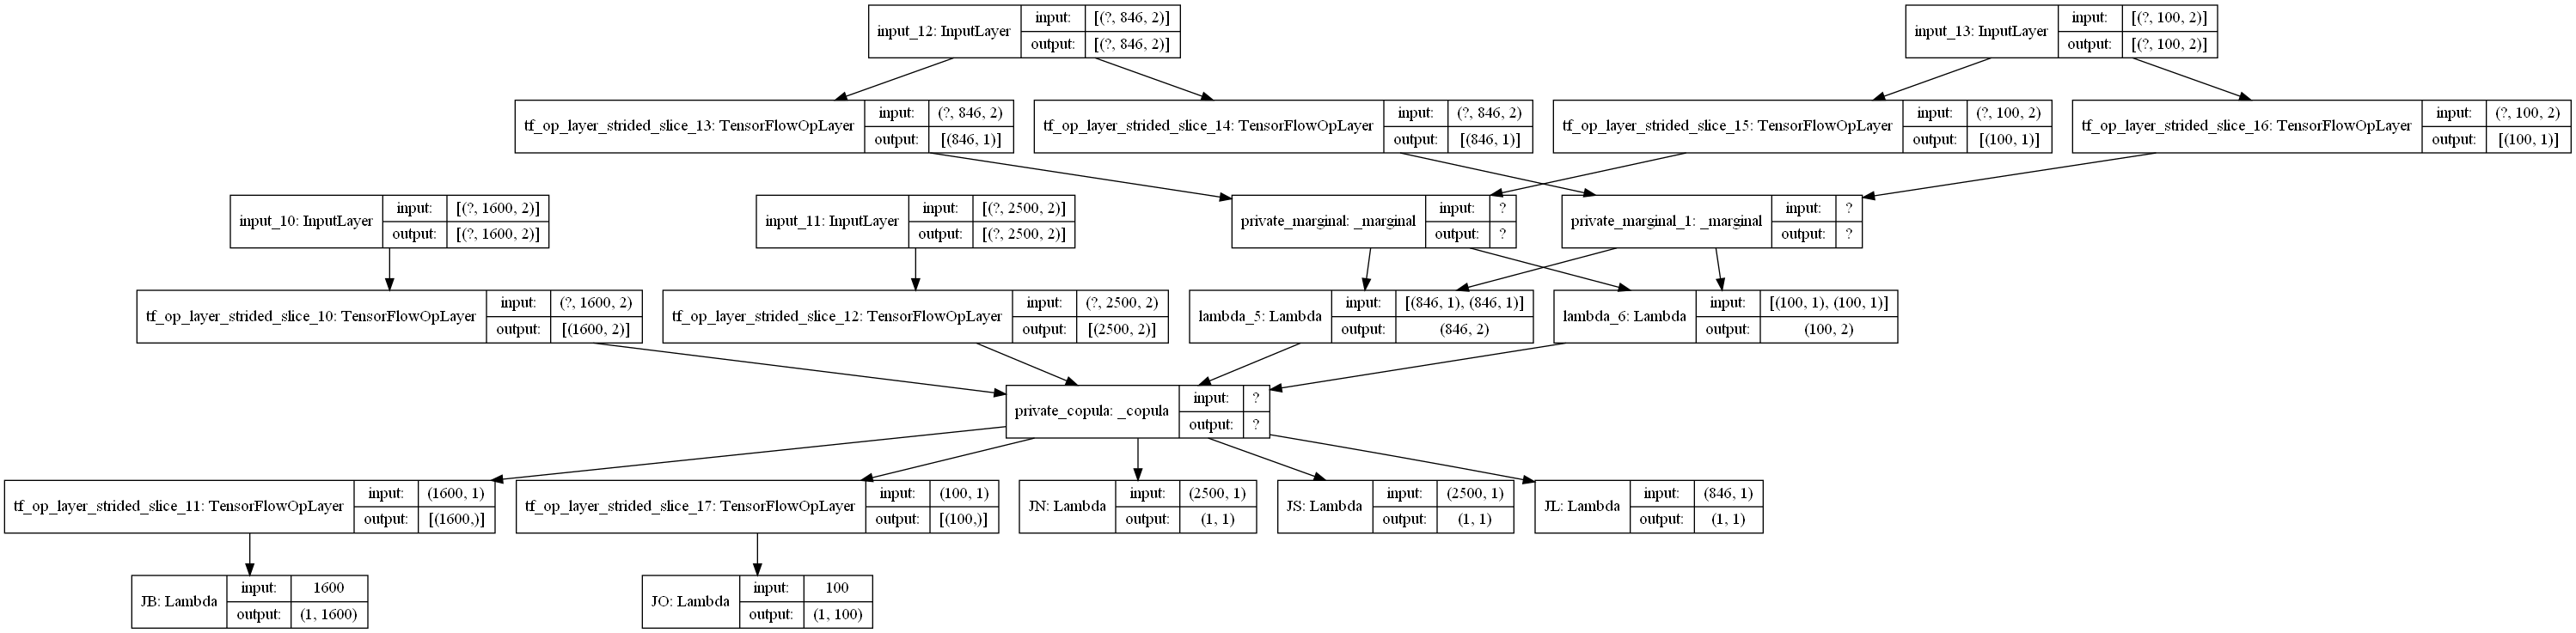

In [32]:
joint_model_train = keras.Model(inputs=joint_loss_input_list, 
                                outputs=joint_loss_output_list)
tf.keras.utils.plot_model(joint_model_train, show_shapes=True, show_layer_names=True, to_file='joint_model_train.png')

In [33]:
joint_model_train.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.0001), loss="mae", 
                          experimental_run_tf_function = False)
joint_model_train.save_weights('./initial_weights/joint_model_initial_weights.h5')
temp_history = joint_model_train.fit(x=joint_training_input_data, y=joint_training_labels, epochs=1, verbose=0)
joint_loss_keys = []
for key in temp_history.history.keys():
    joint_loss_keys.append(key)
print(joint_loss_keys)

['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']


In [34]:
class Joint_Model_Training_Callback(tf.keras.callbacks.Callback):
    def __init__(self, record_interval=10, show_interval=100, verbose=1):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.loss_keys = joint_loss_keys
        self.previous_loss = 9999999
        self.record_interval = record_interval;
        self.show_interval = show_interval;
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        
        if epoch%self.record_interval == 0:
            
            current_losses = np.asarray([logs.get(self.loss_keys[i]) for i in range(len(self.loss_keys))])
            current_losses[-2] = 5.0-current_losses[-2]
            
            joint_epoch_number_list.append(epoch)
            joint_losses_list.append(current_losses)
        
            if current_losses[0] < self.previous_loss:
                self.previous_loss = current_losses[0]
                copula_model.save_weights('./best_weights/copula_model_best_weights.h5')
            
            if self.verbose > 0:
                print('epoch:{}'.format(epoch))
                print([self.loss_keys[i] for i in range(len(self.loss_keys))])
                print(['{:.3f}'.format(current_losses[i]) for i in range(len(self.loss_keys))])
            
        if epoch%self.show_interval == 0:
            
            if number_of_dimension ==2:
                domain_sapce = 50
                x_domain = np.linspace(0, 1, domain_sapce)
                y_domain = np.linspace(0, 1, domain_sapce)
                x_mesh,y_mesh = np.meshgrid(x_domain, y_domain)
                Fx_x,fx_x,_=marginal_prediction_model_list[0].predict(x_mesh.view().ravel())
                Fy_y,fy_y,_=marginal_prediction_model_list[1].predict(y_mesh.view().ravel())

                u_v = np.column_stack([Fx_x,Fy_y]).astype(np.float32)
                c_u_v = copula_prediction_model.predict(u_v)[1]
                f_x_y = c_u_v*fx_x*fy_y
                fig, ax = plt.subplots(1,1,constrained_layout=False, figsize=(10, 8))
                ax.axis('equal')
                #
                cs = ax.contourf(x_mesh, y_mesh, f_x_y.reshape(domain_sapce,domain_sapce),100)
                fig.colorbar(cs, ax=ax, shrink=0.9)
                ax.set_xlabel('u')
                ax.set_ylabel('v')
                ax.set_title('fxy')          
                fig.show()
                plt.pause(1)
                
            if number_of_dimension==3:
                x_domain = np.linspace(0, 1, 20)
                y_domain = np.linspace(0, 1, 20)
                z_domain = np.linspace(0, 1, 20)
                x_mesh,y_mesh,z_mesh = np.meshgrid(x_domain, y_domain, z_domain)
                Fx_x,fx_x,_=marginal_prediction_model_list[0].predict(x_mesh.view().ravel())
                Fy_y,fy_y,_=marginal_prediction_model_list[1].predict(y_mesh.view().ravel())
                Fz_z,fz_z,_=marginal_prediction_model_list[2].predict(z_mesh.view().ravel())
                u_v_w = np.column_stack([Fx_x,Fy_y,Fz_z]).astype(np.float32)
                c_u_v_w = copula_prediction_model.predict(u_v_w)[1]
                f_x_y_z = c_u_v_w*fx_x*fy_y*fz_z
                fig = go.Figure(data=go.Volume(x=x_mesh.view().ravel(),
                                               y=y_mesh.view().ravel(),
                                               z=z_mesh.view().ravel(),
                                               value=f_x_y_z,
                                               isomin=f_x_y_z.min(),
                                               isomax=f_x_y_z.max(),
                                               opacity=0.2,
                                               surface_count=20))
                fig.show()
                plt.pause(1)

In [35]:
joint_model_training_callback = [
    Joint_Model_Training_Callback(record_interval=500, show_interval=4000, verbose=1),
]

### 4.2.3. Training the model

In [36]:
for m in marginal_model_list:
    m.trainable = False

epoch:0
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['5.333', '0.371', '0.006', '0.997', '-16.153', '0.248']


C:\Users\zengz\AppData\Local\Temp\ipykernel_23560\1681140513.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


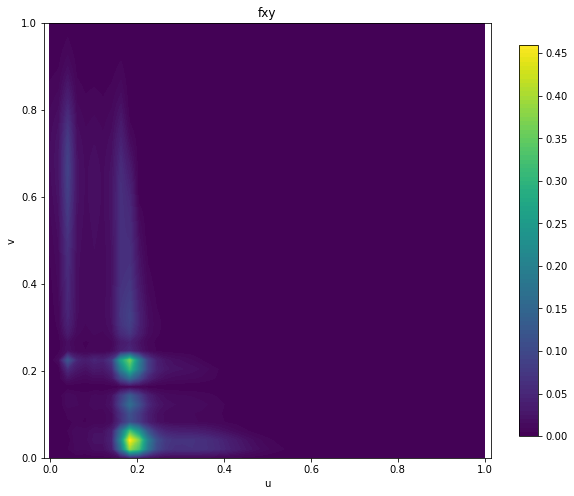

epoch:500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['1.100', '0.086', '0.012', '0.005', '0.234', '0.038']
epoch:1000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['1.034', '0.066', '0.009', '0.008', '0.331', '0.034']
epoch:1500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['1.005', '0.059', '0.007', '0.012', '0.406', '0.031']
epoch:2000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.952', '0.049', '0.008', '0.010', '0.565', '0.027']
epoch:2500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.902', '0.036', '0.004', '0.019', '0.630', '0.022']
epoch:3000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.882', '0.034', '0.008', '0.004', '0.669', '0.021']
epoch:3500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.849', '0.025', '0.004', '0.014', '0.689', '0.017']
epoch:4000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.840', '0.023

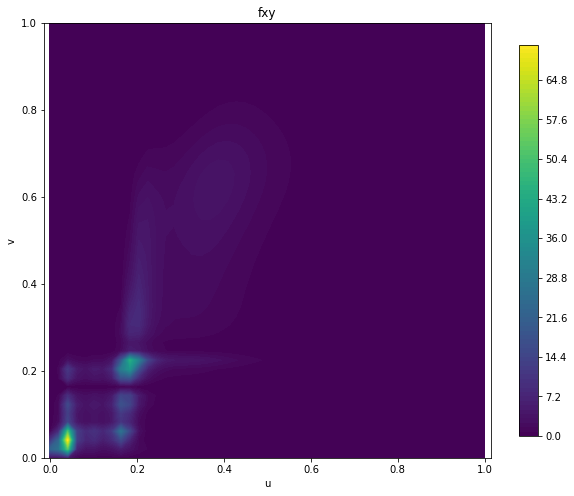

epoch:4500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.822', '0.022', '0.004', '0.005', '0.727', '0.016']
epoch:5000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.812', '0.022', '0.004', '0.001', '0.741', '0.015']
epoch:5500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.815', '0.021', '0.002', '0.007', '0.752', '0.015']
epoch:6000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.808', '0.021', '0.002', '0.005', '0.766', '0.014']
epoch:6500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.800', '0.020', '0.002', '0.003', '0.783', '0.014']
epoch:7000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.799', '0.020', '0.002', '0.002', '0.791', '0.014']
epoch:7500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.799', '0.020', '0.001', '0.001', '0.797', '0.014']
epoch:8000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.794', '0.02

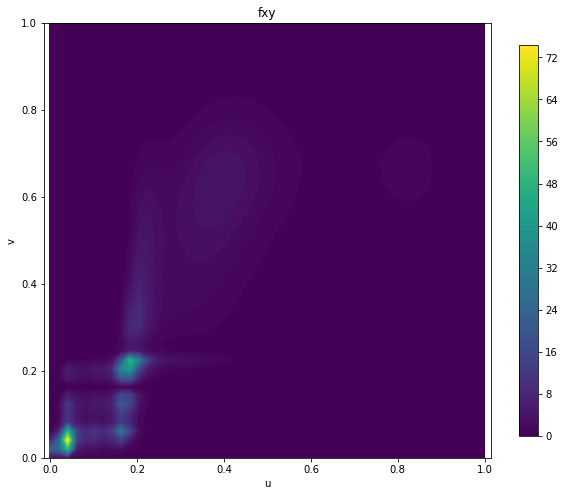

epoch:8500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.790', '0.020', '0.001', '0.003', '0.815', '0.013']
epoch:9000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.791', '0.019', '0.001', '0.005', '0.822', '0.013']
epoch:9500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.792', '0.019', '0.001', '0.007', '0.827', '0.013']
epoch:10000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.793', '0.019', '0.001', '0.007', '0.822', '0.013']
epoch:10500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.782', '0.019', '0.001', '0.001', '0.827', '0.012']
epoch:11000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.787', '0.019', '0.001', '0.005', '0.827', '0.012']
epoch:11500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.786', '0.019', '0.001', '0.006', '0.837', '0.012']
epoch:12000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.783', 

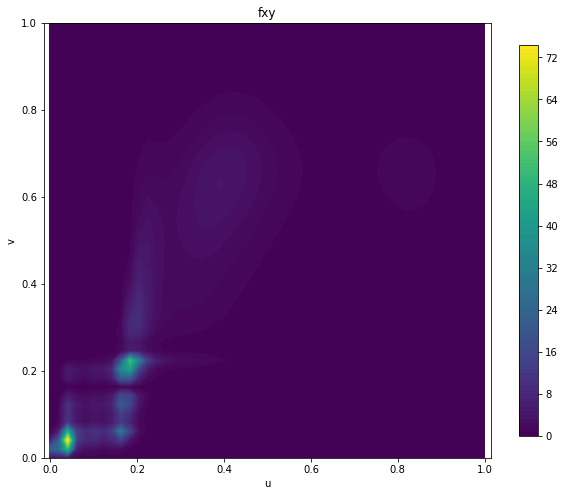

epoch:12500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.780', '0.019', '0.001', '0.001', '0.837', '0.012']
epoch:13000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.781', '0.019', '0.001', '0.002', '0.841', '0.012']
epoch:13500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.779', '0.018', '0.001', '0.004', '0.845', '0.012']
epoch:14000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.784', '0.019', '0.001', '0.007', '0.848', '0.012']
epoch:14500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.778', '0.018', '0.001', '0.005', '0.844', '0.012']
epoch:15000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.773', '0.018', '0.001', '0.000', '0.849', '0.011']
epoch:15500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.778', '0.018', '0.001', '0.000', '0.854', '0.012']
epoch:16000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.774

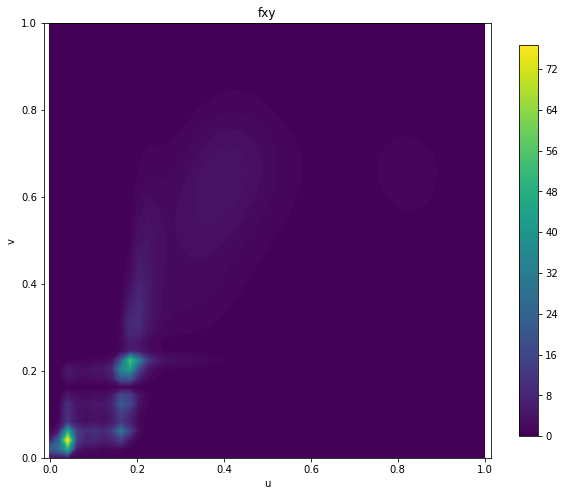

epoch:16500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.779', '0.018', '0.000', '0.004', '0.853', '0.012']
epoch:17000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.769', '0.017', '0.001', '0.000', '0.860', '0.011']
epoch:17500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.772', '0.017', '0.000', '0.003', '0.857', '0.011']
epoch:18000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.770', '0.017', '0.001', '0.000', '0.865', '0.011']
epoch:18500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.774', '0.017', '0.001', '0.005', '0.868', '0.011']
epoch:19000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.769', '0.017', '0.001', '0.000', '0.872', '0.011']
epoch:19500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.773', '0.017', '0.000', '0.005', '0.871', '0.011']
epoch:20000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.770

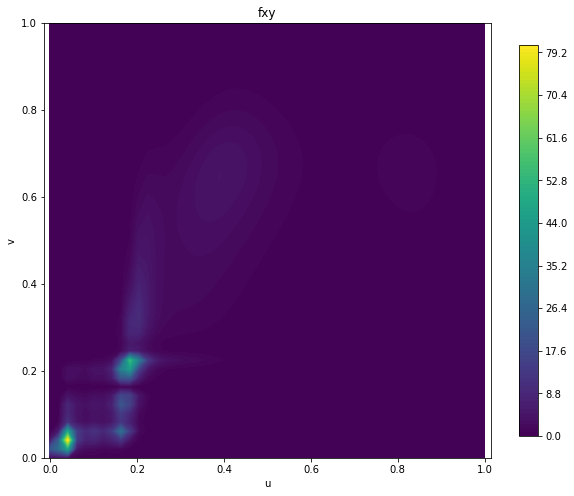

epoch:20500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.767', '0.016', '0.001', '0.001', '0.889', '0.011']
epoch:21000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.763', '0.016', '0.001', '0.000', '0.901', '0.011']
epoch:21500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.760', '0.016', '0.001', '0.000', '0.918', '0.011']
epoch:22000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.760', '0.016', '0.001', '0.003', '0.931', '0.010']
epoch:22500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.757', '0.015', '0.001', '0.000', '0.941', '0.010']
epoch:23000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.757', '0.015', '0.001', '0.001', '0.952', '0.010']
epoch:23500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.756', '0.015', '0.001', '0.001', '0.958', '0.010']
epoch:24000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.750

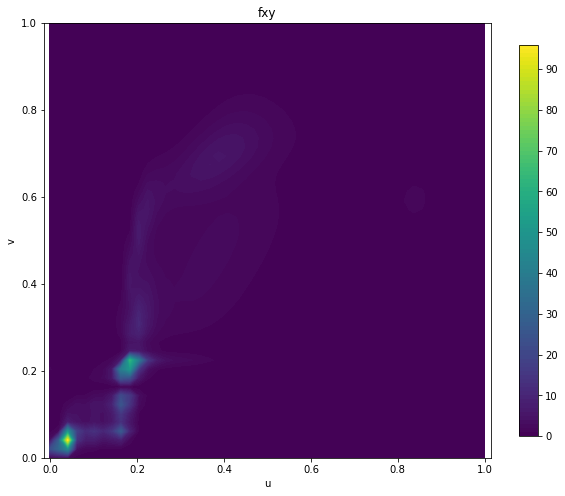

epoch:24500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.751', '0.014', '0.001', '0.001', '0.975', '0.009']
epoch:25000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.754', '0.015', '0.001', '0.003', '0.983', '0.010']
epoch:25500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.751', '0.014', '0.001', '0.003', '0.994', '0.009']
epoch:26000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.746', '0.014', '0.001', '0.002', '1.004', '0.009']
epoch:26500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.744', '0.014', '0.001', '0.000', '1.015', '0.009']
epoch:27000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.749', '0.015', '0.002', '0.002', '1.025', '0.009']
epoch:27500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.744', '0.014', '0.001', '0.002', '1.025', '0.009']
epoch:28000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.742

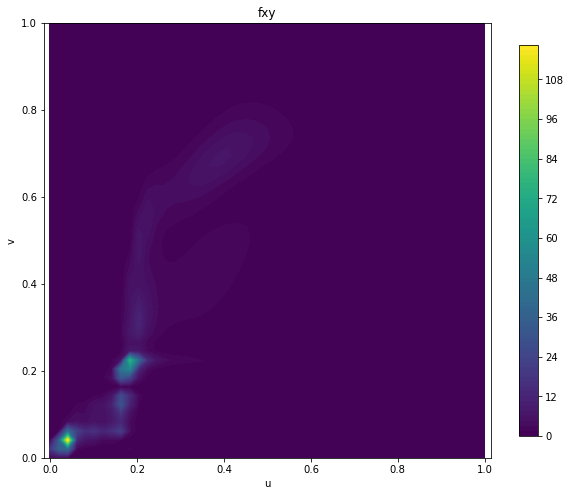

epoch:28500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.742', '0.013', '0.001', '0.002', '1.035', '0.008']
epoch:29000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.742', '0.014', '0.002', '0.001', '1.042', '0.009']
epoch:29500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.739', '0.013', '0.001', '0.000', '1.047', '0.009']
epoch:30000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.739', '0.013', '0.001', '0.001', '1.048', '0.009']
epoch:30500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.738', '0.013', '0.001', '0.000', '1.051', '0.009']
epoch:31000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.741', '0.013', '0.002', '0.002', '1.056', '0.009']
epoch:31500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.737', '0.013', '0.002', '0.000', '1.056', '0.008']
epoch:32000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.736

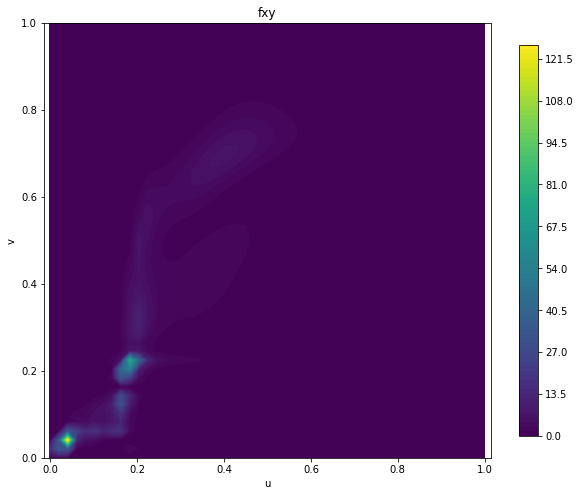

epoch:32500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.736', '0.012', '0.002', '0.002', '1.062', '0.008']
epoch:33000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.735', '0.012', '0.002', '0.000', '1.063', '0.008']
epoch:33500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.742', '0.013', '0.002', '0.004', '1.068', '0.009']
epoch:34000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.734', '0.012', '0.002', '0.000', '1.066', '0.008']
epoch:34500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.734', '0.012', '0.001', '0.001', '1.068', '0.008']
epoch:35000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.735', '0.012', '0.001', '0.002', '1.070', '0.008']
epoch:35500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.735', '0.012', '0.002', '0.002', '1.073', '0.008']
epoch:36000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.736

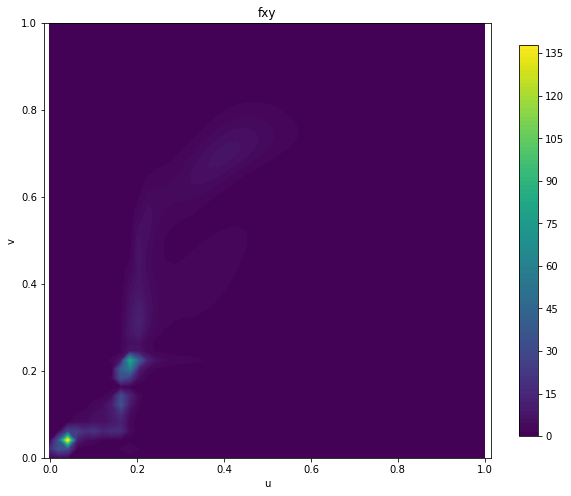

epoch:36500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.731', '0.011', '0.002', '0.000', '1.079', '0.008']
epoch:37000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.737', '0.013', '0.002', '0.001', '1.081', '0.009']
epoch:37500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.732', '0.011', '0.002', '0.002', '1.085', '0.008']
epoch:38000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.731', '0.011', '0.002', '0.001', '1.086', '0.008']
epoch:38500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.730', '0.011', '0.002', '0.000', '1.089', '0.008']
epoch:39000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.732', '0.011', '0.001', '0.003', '1.086', '0.008']
epoch:39500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.729', '0.011', '0.002', '0.000', '1.090', '0.008']
epoch:40000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.730

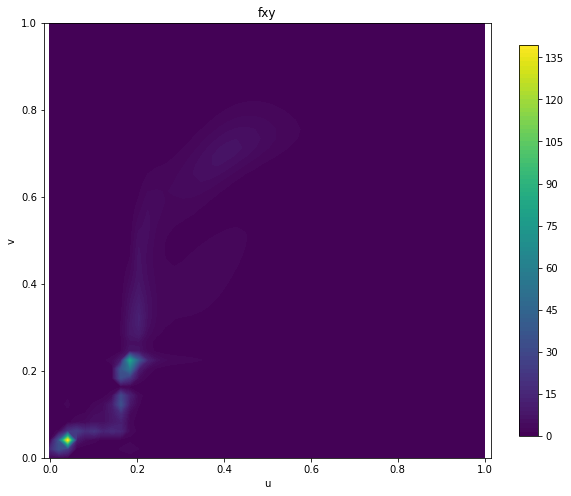

epoch:40500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.728', '0.011', '0.002', '0.001', '1.092', '0.008']
epoch:41000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.731', '0.011', '0.002', '0.003', '1.092', '0.008']
epoch:41500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.728', '0.011', '0.002', '0.001', '1.097', '0.008']
epoch:42000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.726', '0.011', '0.002', '0.000', '1.099', '0.008']
epoch:42500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.729', '0.011', '0.002', '0.002', '1.097', '0.008']
epoch:43000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.728', '0.011', '0.002', '0.002', '1.104', '0.008']
epoch:43500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.727', '0.011', '0.002', '0.002', '1.104', '0.008']
epoch:44000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.727

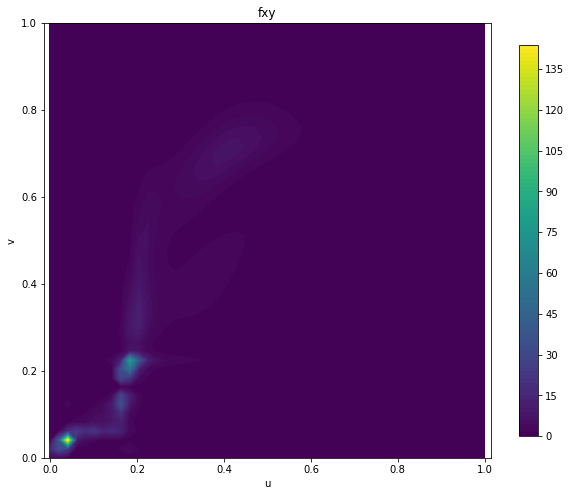

epoch:44500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.728', '0.011', '0.002', '0.003', '1.104', '0.008']
epoch:45000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.726', '0.011', '0.002', '0.000', '1.107', '0.008']
epoch:45500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.728', '0.011', '0.002', '0.003', '1.106', '0.008']
epoch:46000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.729', '0.011', '0.002', '0.002', '1.111', '0.008']
epoch:46500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.730', '0.011', '0.002', '0.001', '1.113', '0.008']
epoch:47000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.730', '0.011', '0.003', '0.002', '1.116', '0.008']
epoch:47500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.725', '0.010', '0.002', '0.002', '1.119', '0.007']
epoch:48000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.726

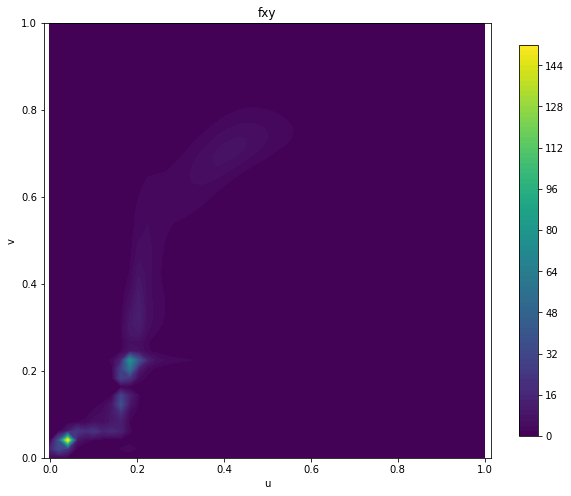

epoch:48500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.722', '0.011', '0.002', '0.000', '1.120', '0.007']
epoch:49000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.722', '0.010', '0.002', '0.000', '1.124', '0.007']
epoch:49500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.721', '0.010', '0.002', '0.000', '1.125', '0.007']
epoch:50000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.725', '0.011', '0.003', '0.002', '1.131', '0.008']
epoch:50500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.723', '0.010', '0.002', '0.001', '1.131', '0.007']
epoch:51000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.722', '0.010', '0.002', '0.001', '1.136', '0.007']
epoch:51500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.720', '0.010', '0.002', '0.000', '1.137', '0.007']
epoch:52000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.725

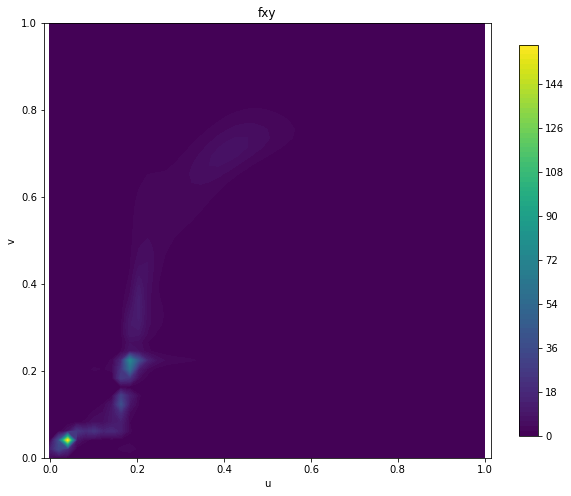

epoch:52500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.720', '0.010', '0.002', '0.002', '1.143', '0.007']
epoch:53000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.722', '0.010', '0.003', '0.001', '1.146', '0.007']
epoch:53500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.717', '0.010', '0.002', '0.000', '1.147', '0.007']
epoch:54000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.722', '0.010', '0.003', '0.001', '1.151', '0.007']
epoch:54500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.717', '0.010', '0.003', '0.001', '1.156', '0.007']
epoch:55000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.718', '0.010', '0.003', '0.001', '1.159', '0.007']
epoch:55500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.716', '0.010', '0.002', '0.000', '1.163', '0.007']
epoch:56000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.718

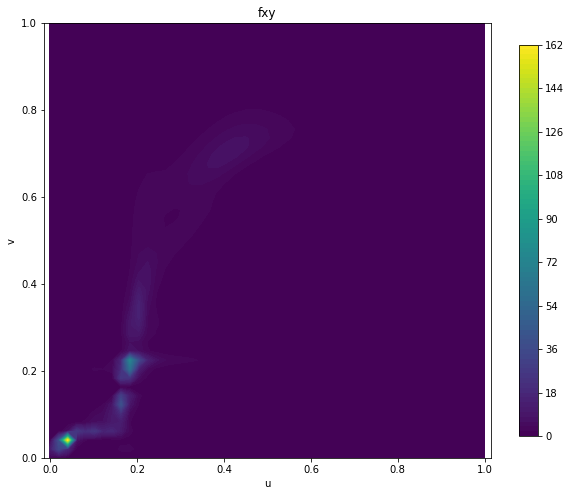

epoch:56500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.719', '0.010', '0.002', '0.002', '1.170', '0.007']
epoch:57000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.716', '0.010', '0.001', '0.002', '1.169', '0.007']
epoch:57500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.717', '0.010', '0.002', '0.001', '1.175', '0.007']
epoch:58000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.715', '0.010', '0.002', '0.002', '1.178', '0.007']
epoch:58500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.714', '0.009', '0.001', '0.002', '1.179', '0.007']
epoch:59000
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.715', '0.010', '0.001', '0.002', '1.184', '0.007']
epoch:59500
['loss', 'JB_loss', 'JN_loss', 'JS_loss', 'JL_loss', 'JO_loss']
['0.712', '0.009', '0.001', '0.001', '1.185', '0.007']
--- 283.33238196372986 seconds ---


In [37]:
joint_epoch_number_list = []
joint_losses_list = []
joint_model_train.load_weights('./initial_weights/joint_model_initial_weights.h5')
joint_model_train.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.001), loss="mae", 
                             loss_weights = [2,1,1,0.1,5])
start_time = time.time()
joint_model_train.fit(x=joint_training_input_data, y=joint_training_labels, 
                         epochs=60000, verbose=0, callbacks=joint_model_training_callback)
print("--- %s seconds ---" % (time.time() - start_time))

### 4.2.4. 计算loss

In [38]:
eval_log_loss_input = keras.layers.Input(shape=(X_test.shape[0],number_of_dimension))
eval_log_loss_marginal_cdfs = Lambda(lambda x: K.concatenate(x, axis=-1))([marginal_model_list[i](eval_log_loss_input[0,:,i:i+1])[0] for i in range(number_of_dimension)])
eval_log_loss_marginal_pdfs = Lambda(lambda x: K.concatenate(x, axis=-1))([marginal_model_list[i](eval_log_loss_input[0,:,i:i+1])[1] for i in range(number_of_dimension)])
eval_log_loss_c = copula_model(eval_log_loss_marginal_cdfs)[1]
eval_log_loss_pdf = eval_log_loss_c*eval_log_loss_marginal_pdfs[:,0:1]*eval_log_loss_marginal_pdfs[:,1:2]
eval_log_loss_output = Lambda(lambda x: tf.math.reduce_sum(tf.math.log(x),keepdims=True)/np.float32(X_test.shape[0]))(eval_log_loss_pdf)

eval_model = keras.Model(inputs=eval_log_loss_input, 
                         outputs=eval_log_loss_output)
eval_log_loss_data = np.expand_dims(X_test,axis=0)
loss = eval_model.predict(eval_log_loss_data)
print('loss = ',loss[0][0])

loss =  1.7289933


In [39]:
eval_log_loss_input = keras.layers.Input(shape=(X_test.shape[0],number_of_dimension))
eval_log_loss_marginal_cdfs = Lambda(lambda x: K.concatenate(x, axis=-1))([marginal_model_list[i](eval_log_loss_input[0,:,i:i+1])[0] for i in range(number_of_dimension)])
eval_log_loss_marginal_pdfs = Lambda(lambda x: K.concatenate(x, axis=-1))([marginal_model_list[i](eval_log_loss_input[0,:,i:i+1])[1] for i in range(number_of_dimension)])
copula_model.load_weights('./best_weights/copula_model_best_weights.h5')
eval_log_loss_c = copula_model(eval_log_loss_marginal_cdfs)[1]
eval_log_loss_pdf = eval_log_loss_c*eval_log_loss_marginal_pdfs[:,0:1]*eval_log_loss_marginal_pdfs[:,1:2]
eval_log_loss_output = Lambda(lambda x: tf.math.reduce_sum(tf.math.log(x),keepdims=True)/np.float32(X_test.shape[0]))(eval_log_loss_pdf)

eval_model = keras.Model(inputs=eval_log_loss_input, 
                         outputs=eval_log_loss_output)
eval_log_loss_data = np.expand_dims(X_test,axis=0)
best_weights_loss = eval_model.predict(eval_log_loss_data)
print('best_weights_loss = ',best_weights_loss[0][0])

best_weights_loss =  1.7260627


### 4.2.5. 散点图

In [40]:
domain_sapce = 200
x_domain = np.linspace(0, 1, domain_sapce)
y_domain = np.linspace(0, 1, domain_sapce)
x_mesh,y_mesh = np.meshgrid(x_domain, y_domain)
Fx_x,fx_x,_=marginal_prediction_model_list[0].predict(x_mesh.view().ravel())
Fy_y,fy_y,_=marginal_prediction_model_list[1].predict(y_mesh.view().ravel())

u_v = np.column_stack([Fx_x,Fy_y]).astype(np.float32)
c_u_v = copula_prediction_model.predict(u_v)[1]
f_x_y = c_u_v*fx_x*fy_y

In [41]:
# Create a flat copy of the array
flat = f_x_y.flatten()/f_x_y.flatten().sum()
sample_indices = np.random.choice(a=flat.size,size=joint_log_loss_data.shape[1], p=flat)

In [42]:
x_samples = x_mesh.flatten()[sample_indices]
y_samples = y_mesh.flatten()[sample_indices]
Fx_x_samples,fx_x_samples,_=marginal_prediction_model_list[0].predict(x_samples.view().ravel())
Fy_y_samples,fy_y_samples,_=marginal_prediction_model_list[1].predict(y_samples.view().ravel())
u_v_samples = np.column_stack([Fx_x_samples,Fy_y_samples]).astype(np.float32)
c_u_v_samples = copula_prediction_model.predict(u_v_samples)[1]
f_x_y_samples = c_u_v_samples*fx_x_samples*fy_y_samples

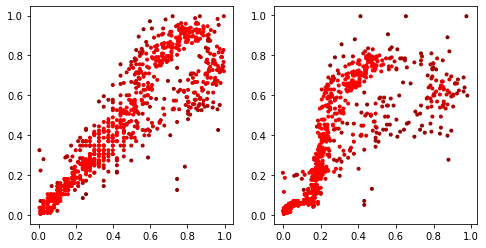

In [43]:
fig = plt.figure(figsize=plt.figaspect(0.5))
#
color_list = np.matlib.repmat(expit(c_u_v_samples), 1, 3)
color_list[:,1:]=0
ax = fig.add_subplot(1, 2, 1)
ax.scatter(u_v_samples[:,0],u_v_samples[:,1],
           c=color_list,marker='.')

color_list = np.matlib.repmat(expit(f_x_y_samples), 1, 3)
color_list[:,1:]=0
ax = fig.add_subplot(1, 2, 2)
ax.scatter(x_samples,y_samples,
           c=color_list,marker='.')